##**INTRODUCTION**

Our main interest behind working on this project was checking if the person will take a coupon or not. To do so, we relied on a dataset that includes details about the destination, the number of people in the car, the weather, the temperature, and other useful information that helps us know the problem and predict better.
We analyzed and found out how these variables interact with each other, which helped us predict if a new customer will take the coupon or not. In order to answer the question mentioned, we tried many models such as Lasso, Ridge and Elastic Net, which will be discussed in the report below, and chose the best one to fit our problem.


In [ ]:
# installation of all required packages 

install.packages('VIM')
install.packages('caret', dependencies = TRUE) # need for confusion matrix
install.packages("mice")
install.packages("glmnet")
install.packages("glm")
install.packages(c("doParallel","foreach","parallel","iterators"))
install.packages('e1071')

# loading libraries
library(VIM)
library(caret)
library("mice")
library(RColorBrewer)
library('glmnet') 
library(doParallel)
library(e1071)
library(pROC)

In [ ]:
draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'Class1', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'Class2', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'Class1', cex=1.2, srt=90)
  text(140, 335, 'Class2', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}  



##**Obtaining Data**

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the paper: Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393. 

In [ ]:
df = read.csv('in-vehicle-coupon-recommendation.csv')
#turning blank into NA
df[df==""|df==NA|df==NaN]<-NA

The dataset is composed by a dataframe which is summariazed as follow:

In [ ]:
summary(df) 

 destination         passanger           weather           temperature  
 Length:12684       Length:12684       Length:12684       Min.   :30.0  
 Class :character   Class :character   Class :character   1st Qu.:55.0  
 Mode  :character   Mode  :character   Mode  :character   Median :80.0  
                                                          Mean   :63.3  
                                                          3rd Qu.:80.0  
                                                          Max.   :80.0  
     time              coupon           expiration           gender         
 Length:12684       Length:12684       Length:12684       Length:12684      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                           

**Attribute Name** | **Attribute Value(s)**
-------------------|----------------------------------------------------
Destination        | *No Urgent Place, Home, Work*
Passenger(Who are the passengers in the car) | *Alone, Friend(s), Kid(s), Partner*
Weather            | *Sunny, Rainy, Snowy*
Temperature        | *55, 80, 30*
Time               | *2PM, 10AM, 6PM, 7AM, 10PM*
    Coupon         | *Restaurant(<$20), Coffee House, Carry Out and Take Away, Bar, Restaurant($20-$50)*
Expiration (After how much time the coupon expires)    | *1d, 2h*
        Gender     | *Male, Female*
        Age        | *21, 46, 31, 41, 50plus, 36, below21*
Marital Status     | *Unmarried Partner, Single, Married Partner, Divorced, Widowed*
     Has Children  | *1, 0*
      Education    | *Some College-No Degree, Bachelor's Degree, Associates Degree, High School Graduate, Graduate Degree(Masters or Doctorate), Some High School*
Occupation         | *Unemployed,  Architecture & Engineering,            Student, Education and Training and Library, Healthcare Support, Healthcare Practitioners & Technical, Sales & Related, Management,*
| *Arts Design Entertainment Sports & Media, Computer & Mathematical, Life Physical Social Science, Personal Care & Service, Community & Social Services,*
| *Office & Administrative Support, Construction & Extraction, Legal, Retired, Installation Maintenance & Repair, Transportation & Material Moving, Business & Financial,*
| *Protective Service, Food Preparation & Serving Related, Production Occupations, Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry*
Income             | *\$37500 - \$49999 , \$62500 - \$74999 , \$12500 - \$24999 , \$75000 - \$87499 , \$50000 - \$62499 , \$25000 - \$37499 , \$100000 or More , \$87500 - \$99999 , Less than \$12500*
Bar (How many times you go to a bar per month)| *Never, Less 1, 1 ~ 3, 4 ~ 8, Gt8, Nan*
Coffee House (How many times you go to a coffee house per month)| *Never, Less 1, 1 ~ 3, 4 ~ 8, Gt8, Nan*
Take Away (How many times you get take away food per month)| *Never, Less 1, 1 ~ 3, 4 ~ 8, Gt8, Nan*
Restaurant Less than 20 (How many times per month you go to a restaurant with average expenses per person of less than 20\$) |*Never, Less 1, 1 ~ 3, 4 ~ 8, Gt8, Nan*
Restaurant 20 to 50 (How many times per month you go to a restaurant with average expenses per person of 20\$ - 50\$)| *Never, Less 1, 1 ~ 3, 4 ~ 8, Gt8, Nan*
Restaurant 20 to 50 (How many times per month you go to a restaurant with average expenses per person of 20\$ - 50\$)| *Never, Less 1, 1 ~ 3, 4 ~ 8, Gt8, Nan*
To Coupon GEQ 15 mins (Driving distance to the restaurant/bar for using the coupon is greater than 15 minutes)| *0, 1*
To Coupon GEQ 25 mins (Driving distance to the restaurant/bar for using the coupon is greater than 25 mins)| *0, 1*
Direction Same (Whether your restaurant/bar is in the same direction as your current destination)| *0, 1*
Y (Whether the coupon is accepted or not) | *0, 1*


##Clean and filter data

Our main goal was getting the best out of the data we had. The better the data, the more efficient the analysis. So, we first focused on getting a high-quality data. To do so, we followed many steps as follows:

-	Converting variables into factors: 
Before starting with MICE, we converted the variables to factors. This is more practical in statistical modelling, graphics and memory storing.


In [ ]:
df$temperature <- as.factor(df$temperature)
levels(df$temperature) <- c("-1.1", "12.8", "26.7") #temperature in Celsius 
df$Bar=as.factor(df$Bar)
df$CoffeeHouse=as.factor(df$CoffeeHouse)
df$CarryAway=as.factor(df$CarryAway)
df$RestaurantLessThan20=as.factor(df$RestaurantLessThan20)
df$Restaurant20To50=as.factor(df$Restaurant20To50)

-	Categories Combination:
Some variables had many categories, some of which were useless. For this reason, we decided to reduce them, in a way that does not affect the results. 



1.   We initially had 3 weather conditions: Rainy, Sunny and Snowy as shown in the barplot below. As Sunny and Snowy both happen under bad weather conditions such as a non-sunny day, we reduced the categories to 2 as follows: Sunny and Not Sunny.




     Rainy      Snowy      Sunny 
0.09539577 0.11076947 0.79383475 

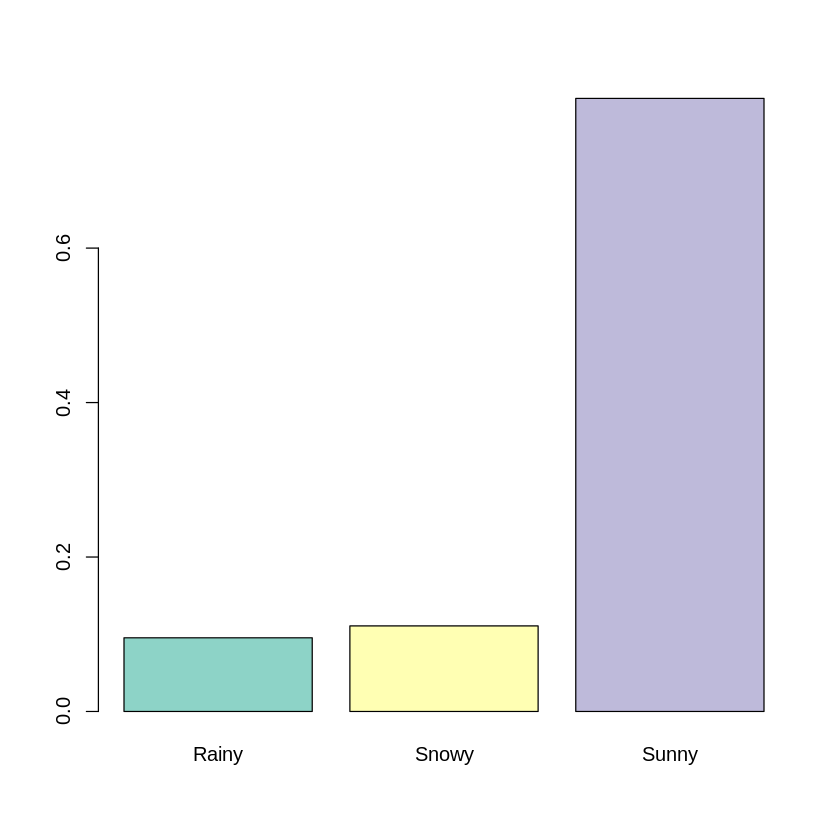

In [ ]:
#look at weather variable
cols <- brewer.pal(10, "Set3")
prop.table(table(df$weather))
barplot(prop.table(table(df$weather)),col=cols)


Not sunny     Sunny 
0.2061652 0.7938348 

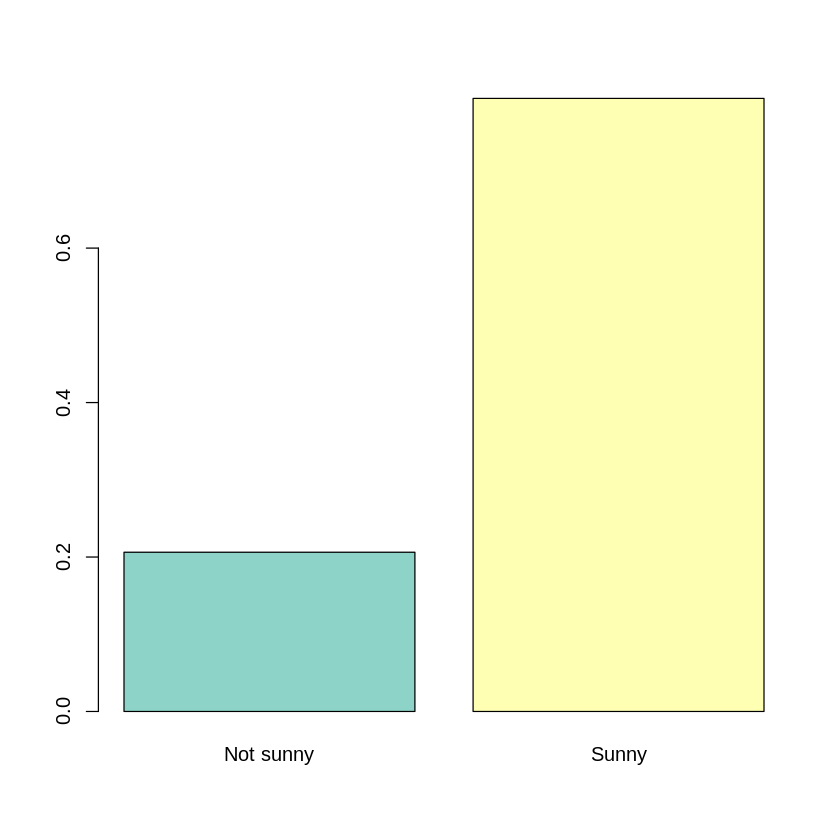

In [ ]:
df$weather[df$weather != 'Sunny'] <- 'Not sunny'
# change the column name
names(df)[names(df) == "weather"] <- "sunny_day"
# barplot
#look at weather variable
prop.table(table(df$sunny_day))
barplot(prop.table(table(df$sunny_day)),col=cols)

 

2.   For the age variable, we decreased the number of categories from 8 to 5 as seen in the figure below. We merged the ages that are quite close to each other. We put each 10 years in the same category. The 5 new categories are as follows: 21-30, 31-40, 41-50, 50 plus and below 21. 

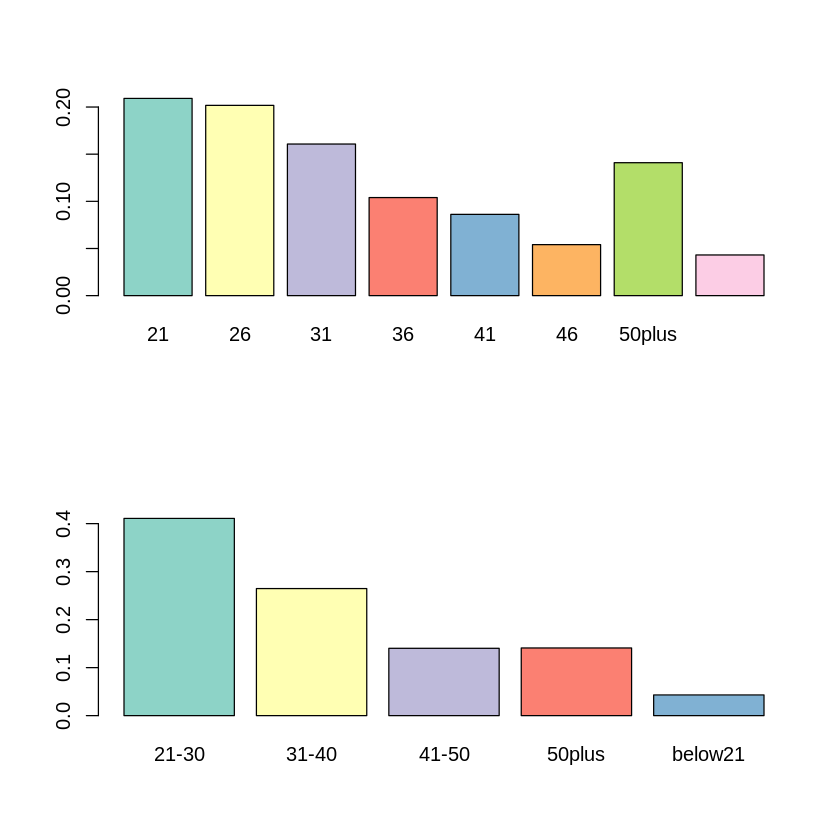

In [ ]:
par(mfrow=c(2,1))
barplot(prop.table(table(df$age)),  col = cols)
df$age[df$age == '21' | df$age == '26'] <- '21-30'
df$age[df$age == '31' | df$age == '36'] <- '31-40'
df$age[df$age == '41' | df$age == '46'] <- '41-50'
barplot(prop.table(table(df$age)), col = cols)
par(mfrow=c(1,1))


3.   Occupation had too many divisions. Some of them were very similar. For example, we had one for Healthcare Support, one for Healthcare Practitioners & Technical, one for Personal Care & Service and one for Protective Service. We merged the 4 mentioned categories into one named: Healthcare. At the end, we got only 6 instead of 25 categories, labeled as the general name of the sector: Healthcare; Administration, Business & Management; Construction, Building & Transportation; Education, Training & Social Works; Architecture, Engineering and Legal; Farming Fishing, Forestry and Production Occupations.

In [ ]:
df$occupation[df$occupation == 'Healthcare Support' | df$occupation == 'Healthcare Practitioners & Technical' 
  | df$occupation == 'Personal Care & Service' | df$occupation == 'Protective Service'] <- 'Healthcare'
df$occupation[df$occupation == 'Office & Administrative Support' 
  | df$occupation == 'Management'  | df$occupation == 'Business & Financial'] <- 'Administration, business and management'
df$occupation[df$occupation == 'Construction & Extraction' | df$occupation == 'Building & Grounds Cleaning & Maintenance' 
  | df$occupation == 'Installation Maintenance & Repair' | df$occupation == 'Transportation & Material Moving'] <- 'Construction, building and Transportation '
df$occupation[df$occupation == 'Education&Training&Library' | df$occupation == 'Community & Social Services' ] <- 'Education, Training and Social works'
df$occupation[df$occupation == 'Architecture & Engineering' | df$occupation == 'Legal' ] <- 'Architecture & Engineering & Legal'
#those with fewer examples
df$occupation[df$occupation == 'Farming Fishing & Forestry' | df$occupation == 'Production Occupations' ] <- 'Farming Fishing, Forestry and Production Occupations'


4. As for the income variable, two income classes were merged into one and the total number of categories changed from 8 to 4.The 4 new categories are shown in the barplots below and are as follow: Less than \$25000, \$25000 - \$50000, \$50000 - \$75000 and \$75000 - \$100000. 

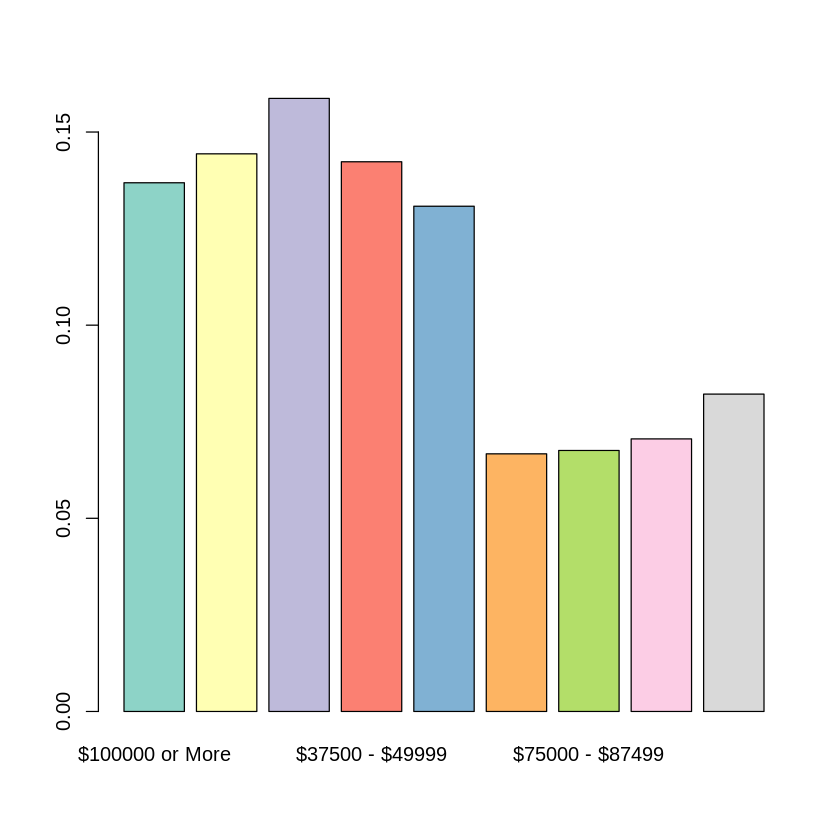

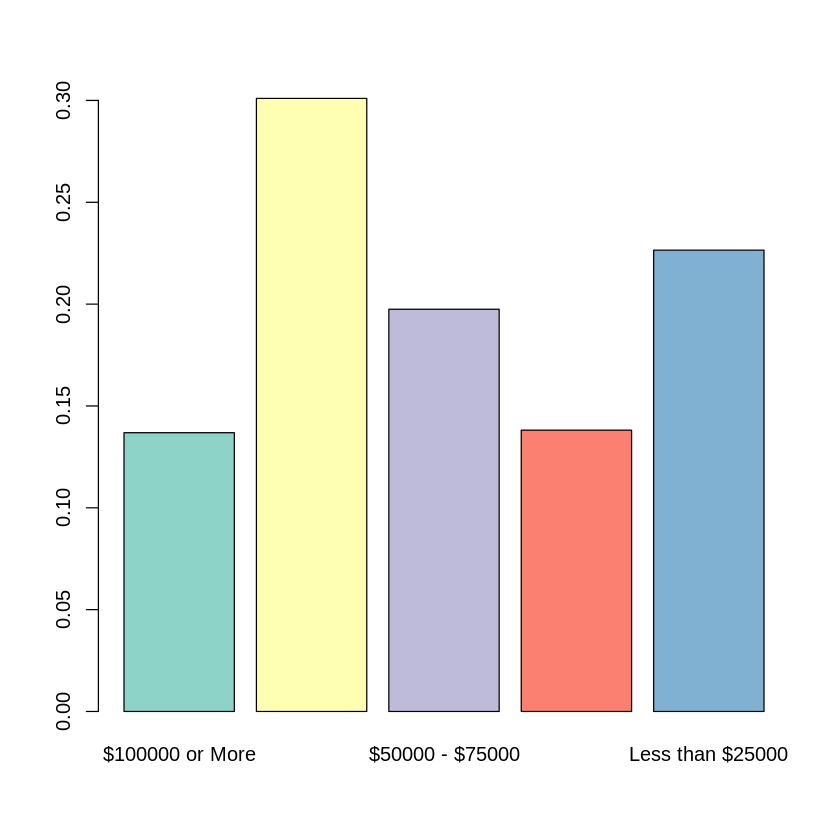

In [ ]:
# income
barplot(prop.table(table(df$income)), col = cols)
df$income[df$income == 'Less than $12500' | df$income == '$12500 - $24999'] <- 'Less than $25000'
df$income[df$income == '$25000 - $37499'  | df$income == '$37500 - $49999'] <- '$25000 - $50000'
df$income[df$income == '$50000 - $62499'  | df$income == '$62500 - $74999'] <- '$50000 - $75000'
df$income[df$income == '$75000 - $87499'  | df$income == '$87500 - $99999'] <- '$75000 - $100000'
barplot(prop.table(table(df$income)), col = cols)


5. For the education variable, we had 5 categories. We now have only 2 categorized as: Educated and Non-Educated labeled as 0 and 1.

In [ ]:
#"education" -> tertiary 0/1
df$education[df$education == 'Some college - no degree'| df$education =='High School Graduate' | df$education =='Some High School'] <- 0
df$education[df$education!=0] <- 1



*  After seeing the values of some columns, we noticed that the whole column either has the same values for all the rows, is a duplicate of another column or is the exact opposites of other column. These were not informative for our analysis so we dropped them: car, direction_opp, toCoupon_GEQ5min



In [ ]:
# removing car column
df <- subset(df, select = -(car) )
# removing direction_opp because is not informative
df <- subset(df, select = -(direction_opp) )
# remove also toCoupon_GEQ5min variable because is all 1
df <- subset(df, select = -(toCoupon_GEQ5min) )


Before removing or modifying the example value we divide the dataframe in training and test sets.

In [ ]:
## 75% of the sample size
smp_size <- floor(0.75 * nrow(df))

## set the seed to make your partition reproducible
set.seed(42)
train_ind <- sample(seq_len(nrow(df)), size = smp_size)

train_df <- df[train_ind, ]
test_df <- df[-train_ind, ]
# dimension of train and test set
dim(train_df)
dim(test_df)


[1] 9513   23

[1] 3171   23


 Variables sorted by number of missings: 
             Variable      Count
          CoffeeHouse 0.01755492
     Restaurant20To50 0.01461158
            CarryAway 0.01166824
 RestaurantLessThan20 0.01009145
                  Bar 0.00767371
          destination 0.00000000
            passanger 0.00000000
            sunny_day 0.00000000
          temperature 0.00000000
                 time 0.00000000
               coupon 0.00000000
           expiration 0.00000000
               gender 0.00000000
                  age 0.00000000
        maritalStatus 0.00000000
         has_children 0.00000000
            education 0.00000000
           occupation 0.00000000
               income 0.00000000
    toCoupon_GEQ15min 0.00000000
    toCoupon_GEQ25min 0.00000000
       direction_same 0.00000000
                    Y 0.00000000


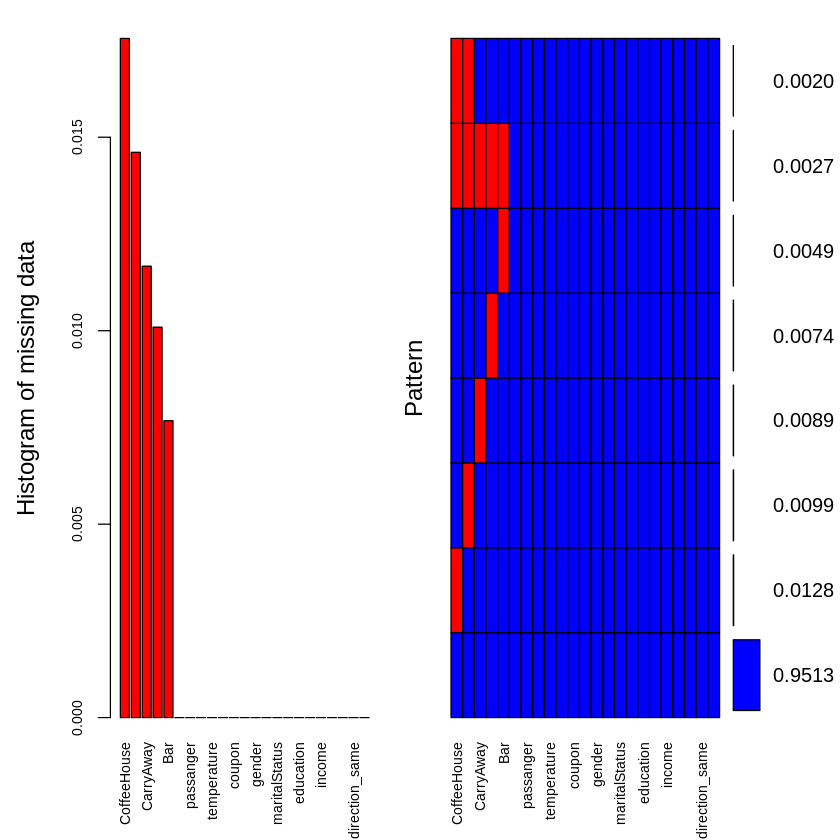

In [ ]:
aggr_plot <- aggr(train_df, col=c('blue','red'), numbers=TRUE, sortVars=TRUE, 
              labels=names(train_df), cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

Checking for missing values: These missing values were an obstacle for our analysis. In order to impute them the best way possible and avoid bad influence of this imputation on our prediction process, we chose the R package ‘MICE’.

**Column** | **Number of Missing Values**
-------------------|----------------------------------------------------
Bar        | *107*
Coffee House | *217*
Carry Away            | *151*
Restaurant Less than 20        | *130*
Restaurant 20 to 50               | *189*

In [ ]:
# instead of removing all the example with missing value we can remove the ones
# which has the following missing variable :CarryAway RestaurantLessThan20 Restaurant20To50 Bar(in the same time)
# (around 40 examples in total dataframe)
nrow(train_df) 
train_df <- subset(train_df,!is.na(CarryAway) | !is.na(RestaurantLessThan20) | !is.na(Restaurant20To50) | !is.na(Bar)) 
nrow(train_df) 

[1] 9513

[1] 9487


 Variables sorted by number of missings: 
             Variable       Count
          CoffeeHouse 0.014862443
     Restaurant20To50 0.011911036
            CarryAway 0.008959629
 RestaurantLessThan20 0.007378518
                  Bar 0.004954148
          destination 0.000000000
            passanger 0.000000000
            sunny_day 0.000000000
          temperature 0.000000000
                 time 0.000000000
               coupon 0.000000000
           expiration 0.000000000
               gender 0.000000000
                  age 0.000000000
        maritalStatus 0.000000000
         has_children 0.000000000
            education 0.000000000
           occupation 0.000000000
               income 0.000000000
    toCoupon_GEQ15min 0.000000000
    toCoupon_GEQ25min 0.000000000
       direction_same 0.000000000
                    Y 0.000000000


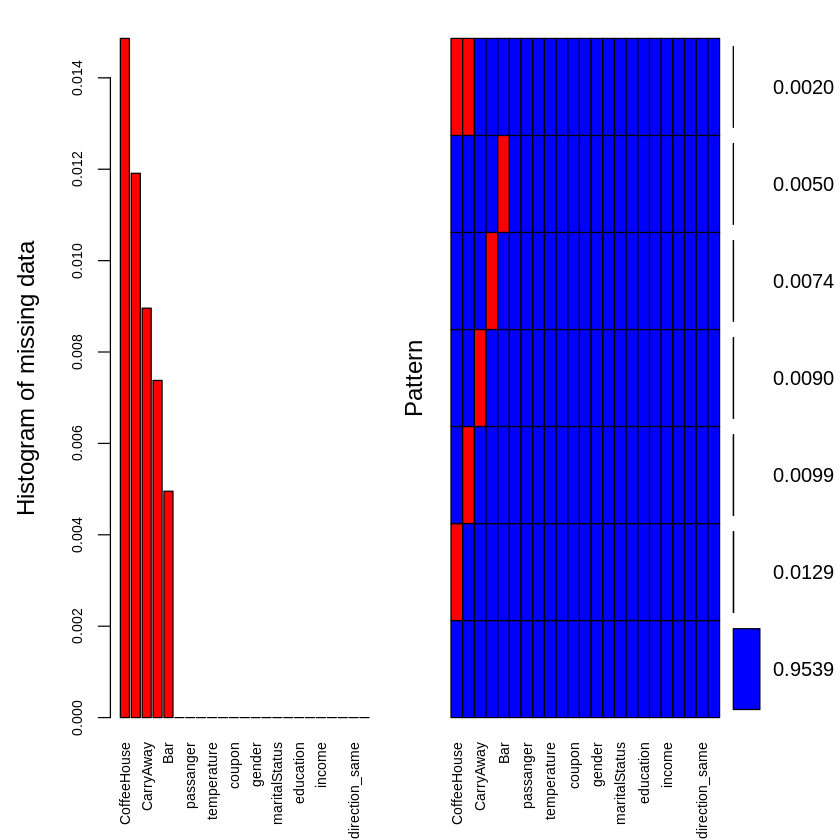

In [ ]:
aggr_plot <- aggr(train_df, col=c('blue','red'), numbers=TRUE, sortVars=TRUE, 
              labels=names(train_df), cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

##MICE 
Implementing MICE: 
MICE stands for Multivariate Imputation via Chained Equations. It predicts missing values It assumes that they are missing at random (MAR). It creates multiple imputations comparing it to one. Every variable is specified a model which makes the prediction in a variable-by-variable way. In our case, and since our variables are factors, we chose “polyreg” for all our variables’ missing values. MICE function takes the following arguments:
•	Corresponding dataset’s 
•	m: number of imputed datasets
•	maxit: number of iterations taken to impute missing values.
•	methods used in imputation for each variable that has missing values.
We were able to reach a certain level of accuracy with MICE prediction and a zero number of missing values.


In [ ]:
# mice
my_imp = mice(train_df,m=1,method=c("","","","","","","","","","","","","","","polyreg","polyreg","polyreg","polyreg","polyreg","","","",""), maxit=20)
final_clean_dataset = complete(my_imp,1)
train_df = final_clean_dataset


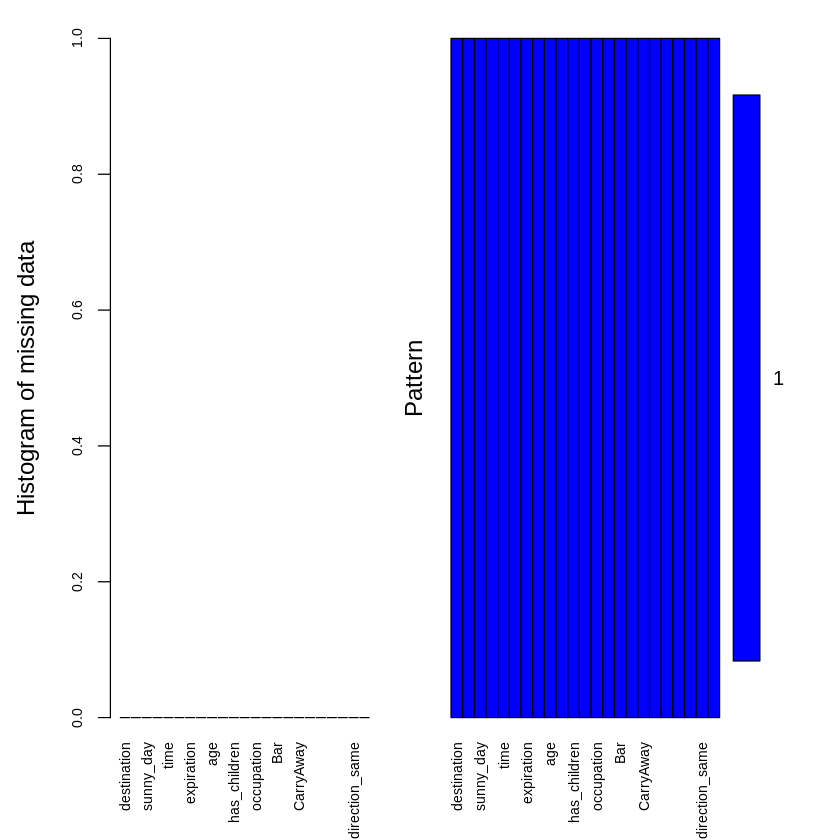

In [ ]:
aggr_plot <- aggr(train_df, col=c('blue','red'), numbers=TRUE, sortVars=FALSE, 
             labels=names(train_df), cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

In the figure below are displayed the final plot frequencies for our variables.

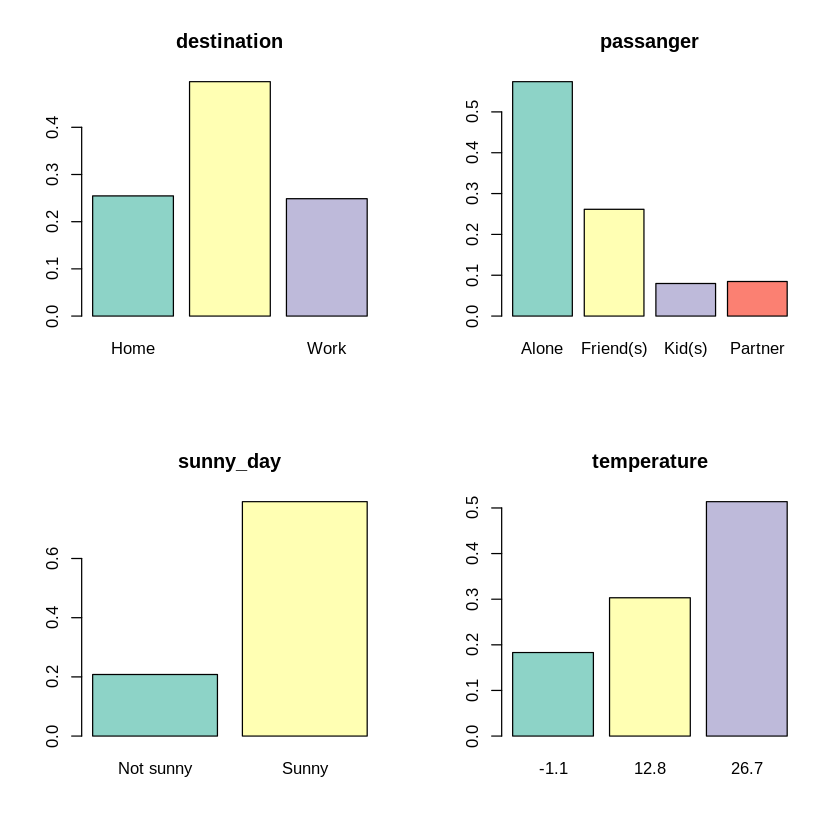

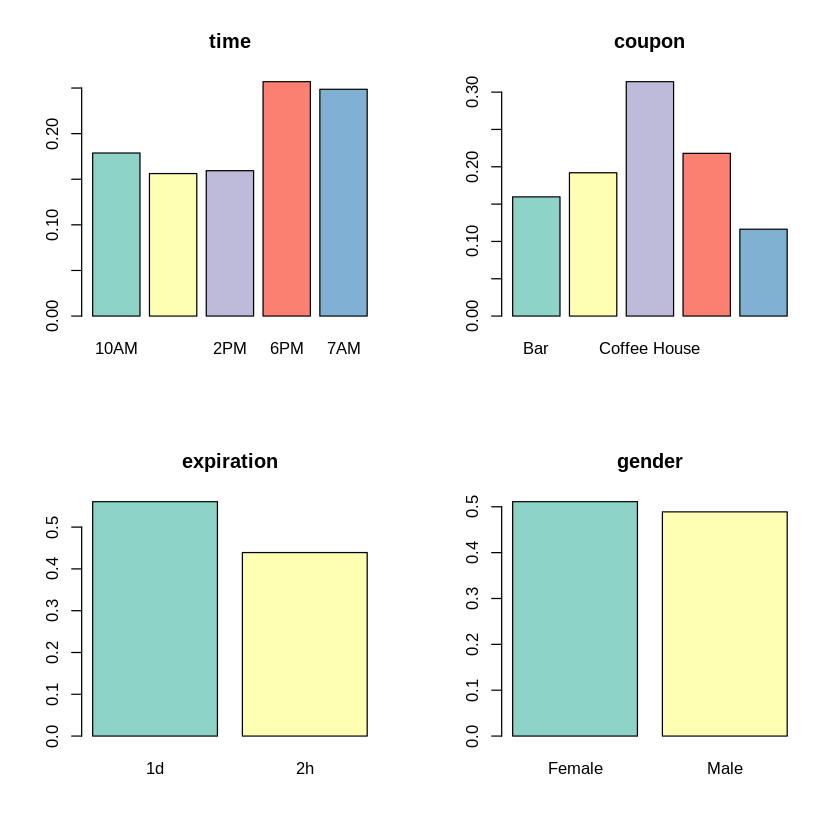

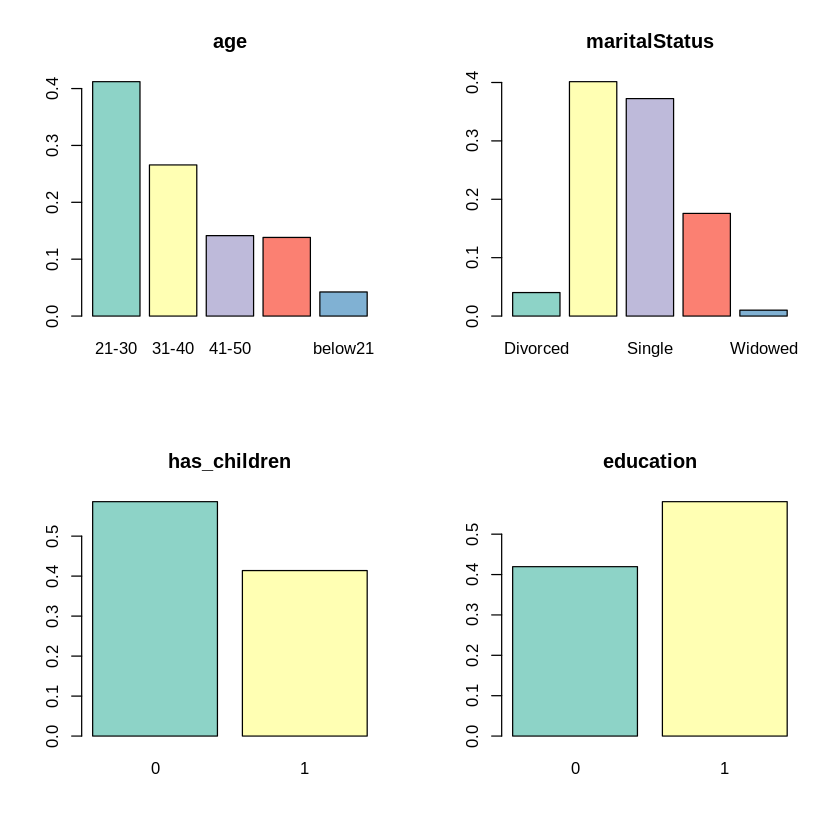

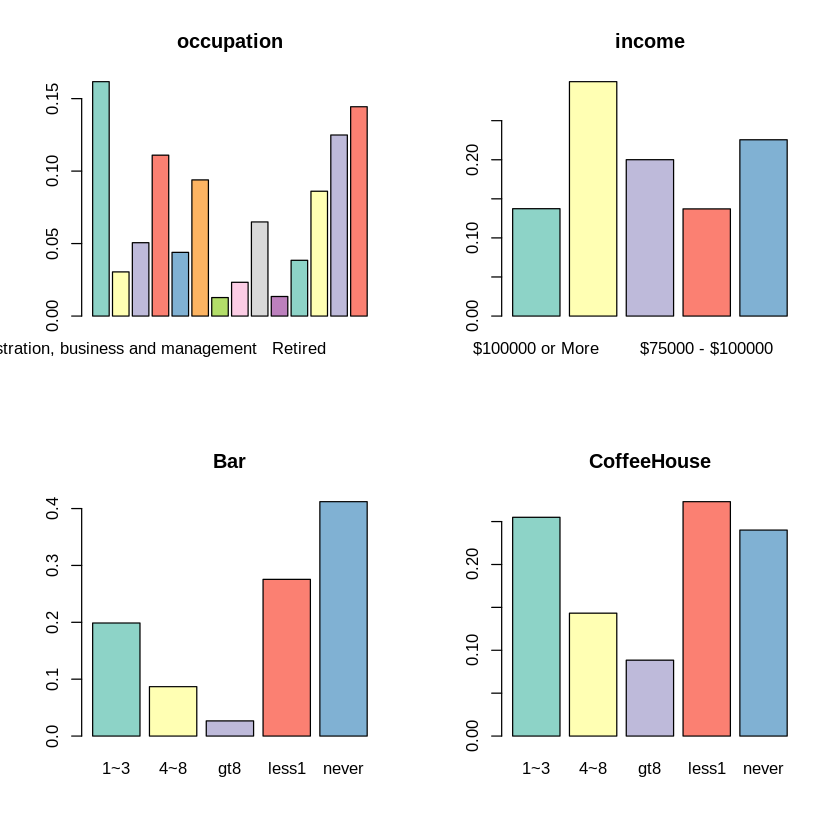

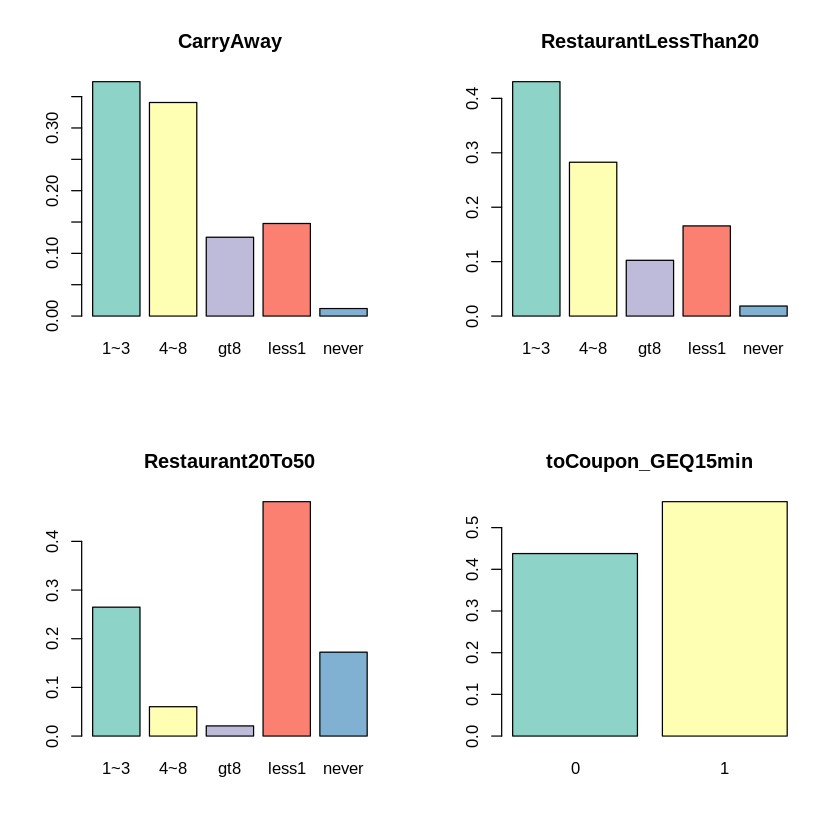

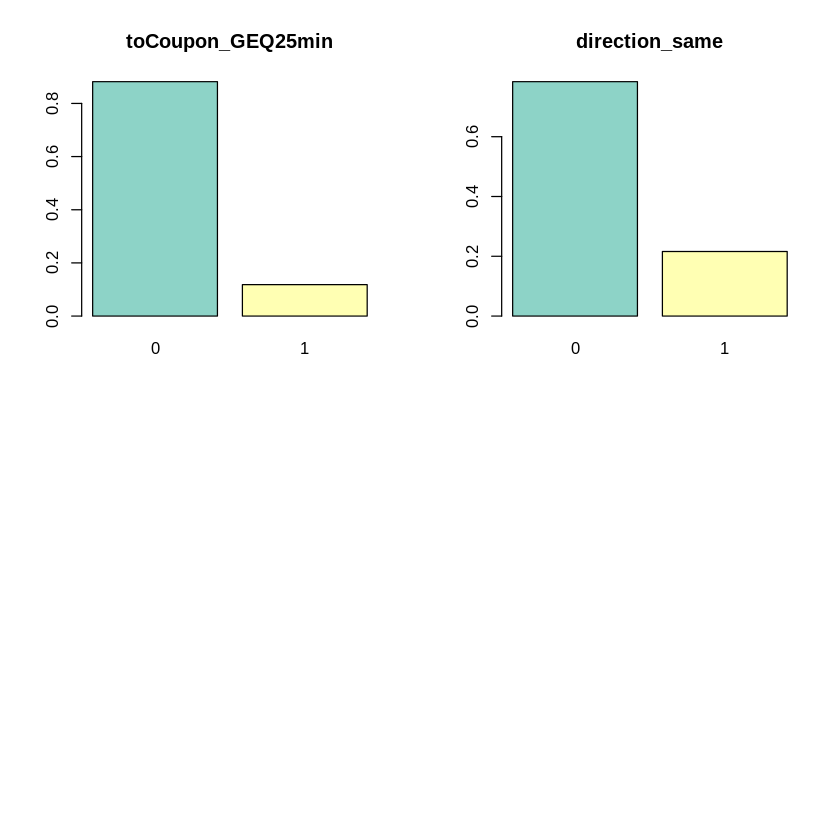

In [ ]:
cols <- brewer.pal(10, "Set3")
par(mfrow=c(2,2))
for (i in 1:ncol(train_df[-23])){
  barplot(prop.table(table(train_df[i])), main = colnames(train_df[i]),col = cols)
}
par(mfrow=c(1,1))

In the figure below are displayed the plot frequencies for training target prediction.

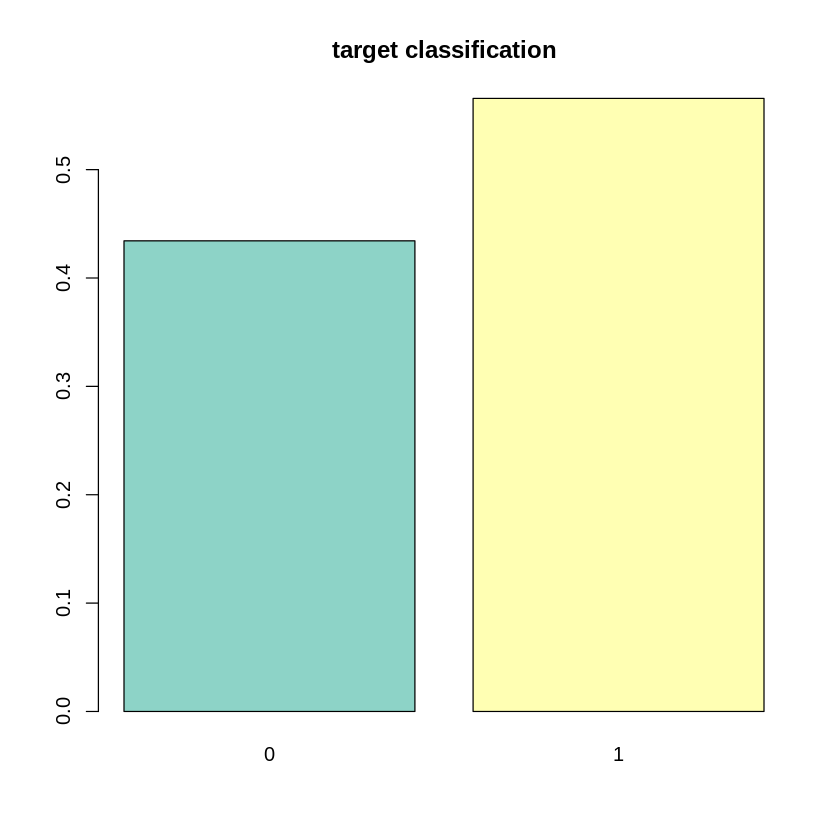

In [ ]:
barplot(prop.table(table(train_df[23])), main = 'target classification',col = cols)

Here we will apply the MICE method discussed above again for our test data.

In [ ]:
# MICE for test set
# impute test data based on train imputation model

test_imp <- mice.mids(my_imp, test_df, maxit = 20)
final_clean_dataset = complete(test_imp,1)
test_imp = final_clean_dataset

# Note: The imputation model itself is specified in the mice() 
# function and cannot be changed with mice.mids. The state of 
# the random generator is saved with the mids object.
X_test <- model.matrix(Y~.,test_imp)
X_test <- X_test[,-1]

# Ridge Regression 

Over-fitting means that the model learns the training data too well, which gives high accuracy in training dataset, fails in learning on the test dataset. Regularization is a technique that helps overcoming over-fitting problems in machine learning models. It helps to keep the parameters regular or normal. Training a model means learning good weights and bias from the dataset. Cost function is an indicator to measure how well the learning process is, i.e. try to minimize the cost function during training. Ridge regression adds a penalty item equivalent to square of the magnitude of the coefficients to the cost function. The penalty item is called L_2 regularization. It helps limit the cost function's convergence to a certain extent, maintaining the generalization of the model, in order to increase the accuracy in the testing dataset. 

In [ ]:
############################
#     RIDGE REGRESSION     #
############################

# design matrix 

X_train <- model.matrix(Y~.,train_df)

# remove the first column relative to the intercept 

X_train <- X_train[,-1]

# vector of responses

y_train <- train_df$Y

# grid of lambda values

lam <- seq(from = 0.0001, to = 0.005, length.out = 150)



# ten folds cross-validation 

set.seed(42)
ridge_classifier.cv <- cv.glmnet(X_train, y_train, alpha = 0, nfolds = 10, lambda = lam,
                              type.measure = 'deviance',  family = 'binomial',  standardize=FALSE)



cat("Best lambda for Ridge Regression",round(ridge_classifier.cv$lambda.min,7))





Best lambda for Ridge Regression 0.0007577

In [ ]:
ridge_classifier <- glmnet(X_train,y_train , alpha=1, lambda=ridge_classifier.cv$lambda.min, family='binomial',standardize=FALSE)
coef(ridge_classifier)

69 x 1 sparse Matrix of class "dgCMatrix"
                                                                         s0
(Intercept)                                                    -0.278689390
destinationNo Urgent Place                                      0.651224085
destinationWork                                                 .          
passangerFriend(s)                                              0.213390628
passangerKid(s)                                                -0.259313738
passangerPartner                                                0.180164157
sunny_daySunny                                                  0.481027146
temperature12.8                                                 0.131879423
temperature26.7                                                 0.082233008
time10PM                                                       -0.136258880
time2PM                                                         .          
time6PM                                       

In [ ]:
y_pred <- predict(ridge_classifier,X_test,type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results for Ridge Regression model:",round(accuracy,4)*100,"%")

Accuracy results for Ridge Regression model: 68.31 %

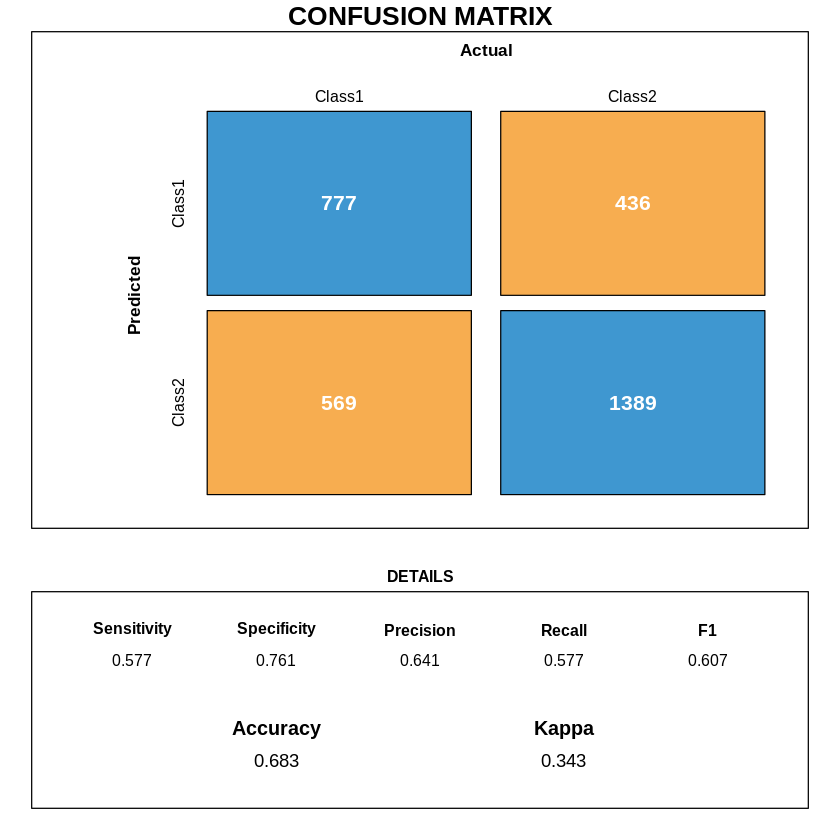

In [ ]:
# calculate the confusion matrix
cm <- confusionMatrix(data = as.factor(y_pred), reference = as.factor(test_df$Y))
draw_confusion_matrix(cm)

# Lasso Regression 


Instead of using Ridge Regression we can use several families of models that implement different types of regularization, such as the Lasso Regression. Basically we are applying a L_1 regularization to our model, so the model is penalized for the sum of absolute values of the weights. Thus, the absolute values of weight will be reduced or will be equal to zero. We can think of Lasso as a special case of variable selection, so the model will learn, by itself, which variables are useful for prediction and which are not. The amount of regularization depends on the lambda hyperparameter, to find the best value for this variable we use a ten fold cross-validation as we did before for the Ridge regression.

In [ ]:
############################
#     LASSO REGRESSION     #
############################


# design matrix 

X_train <- model.matrix(Y~.,train_df)

# remove the first column relative to the intercept 

X_train <- X_train[,-1]

# vector of responses

y_train <- train_df$Y

# grid of lambda values

lam <- seq(from = 0.0001, to = 0.005, length.out = 150)

# Apply glmnet() function

classifier  <- glmnet(X_train ,y_train , alpha=1, lambda = lam, family = 'binomial',standardize=FALSE) 

#classifier


# ten folds cross-validation 

set.seed(42)
classifier.cv <- cv.glmnet(X_train, y_train , alpha = 1, nfolds = 10, lambda = lam,
                              type.measure = 'deviance',  family = 'binomial',  standardize=FALSE)


cat("Best lambda for the Lasso model",round(classifier.cv$lambda.min,5))





Best lambda for the Lasso model 0.00049

In [ ]:
lasso_classifier <- glmnet(X_train ,y_train , alpha=1, lambda=classifier.cv$lambda.min,family='binomial',standardize=FALSE)
coef(lasso_classifier)

69 x 1 sparse Matrix of class "dgCMatrix"
                                                                          s0
(Intercept)                                                    -0.3235037706
destinationNo Urgent Place                                      0.6936961371
destinationWork                                                -0.0120705746
passangerFriend(s)                                              0.2224066969
passangerKid(s)                                                -0.2814655848
passangerPartner                                                0.2014650461
sunny_daySunny                                                  0.4840081428
temperature12.8                                                 0.1609846544
temperature26.7                                                 0.0958554560
time10PM                                                       -0.1479913370
time2PM                                                        -0.0297963268
time6PM                           

In [ ]:
y_pred <- predict(lasso_classifier,X_test,type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results for Lasso Regression model:",round(accuracy,4)*100,"%")

Accuracy results for Lasso Regression model: 68.02 %

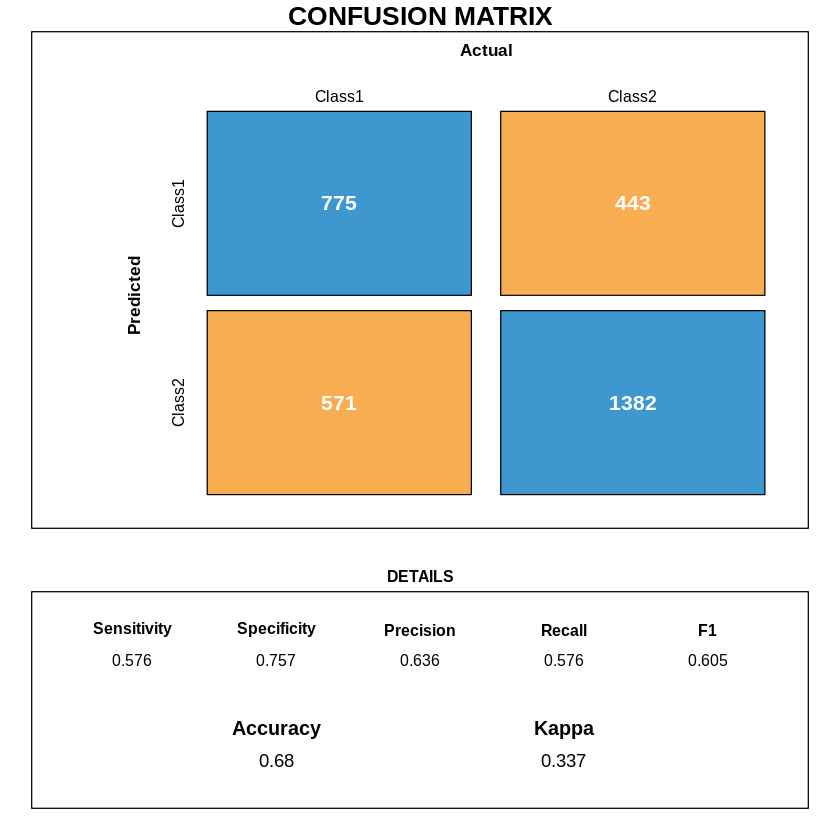

In [ ]:
# calculate the confusion matrix
cm <- confusionMatrix(data = as.factor(y_pred), reference = as.factor(test_df$Y))
draw_confusion_matrix(cm)

This model achieves an accuracy of 68.02%, similar to previous ones using Ridge regression. The lambda value find by the cross validation is very small and therefore the amount of regularization is not so strong, in fact very few coefficients are set to zero. To try to increase the regularization we built another model but in this case we change the type.measure from 'deviance' to 'class' (type.measure="class" applies to binomial and multinomial logistic regression only). As we can see from the values ​​of the coefficients below, we built a more sparse model and the accuracy remains substantially unchanged (68.05 %). With this change we find a lambda value of 0.00184, a large increase respect to the previous one 0.0049. This means that the model is able to find multiple dummy variables that are not useful for prediction and so it sets them to zero.

In [ ]:
lasso_classifier_2.cv = cv.glmnet(X_train, y_train, alpha = 1, nfolds = 10, family = "binomial", lambda = lam, type.measure = 'class',standardize=FALSE)
cat("Best lambda for the Lasso model",round(lasso_classifier_2.cv$lambda.min,5))


Best lambda for the Lasso model 0.00184

In [ ]:
lasso_classifier_2 <- glmnet(X_train, y_train, alpha=1, lambda=lasso_classifier_2.cv$lambda.min, family='binomial',standardize=FALSE)
coef(lasso_classifier_2)

69 x 1 sparse Matrix of class "dgCMatrix"
                                                                         s0
(Intercept)                                                    -0.139270289
destinationNo Urgent Place                                      0.579775383
destinationWork                                                 .          
passangerFriend(s)                                              0.199503055
passangerKid(s)                                                -0.172610576
passangerPartner                                                0.091649760
sunny_daySunny                                                  0.485563009
temperature12.8                                                 0.022006576
temperature26.7                                                 0.017183161
time10PM                                                       -0.123503943
time2PM                                                         .          
time6PM                                       

Prediction

In [ ]:
y_pred <- predict(lasso_classifier_2,X_test,type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results for the modified version of the previous model:",round(accuracy,4)*100,"%")

Accuracy results for the modified version of the previous model: 68.05 %

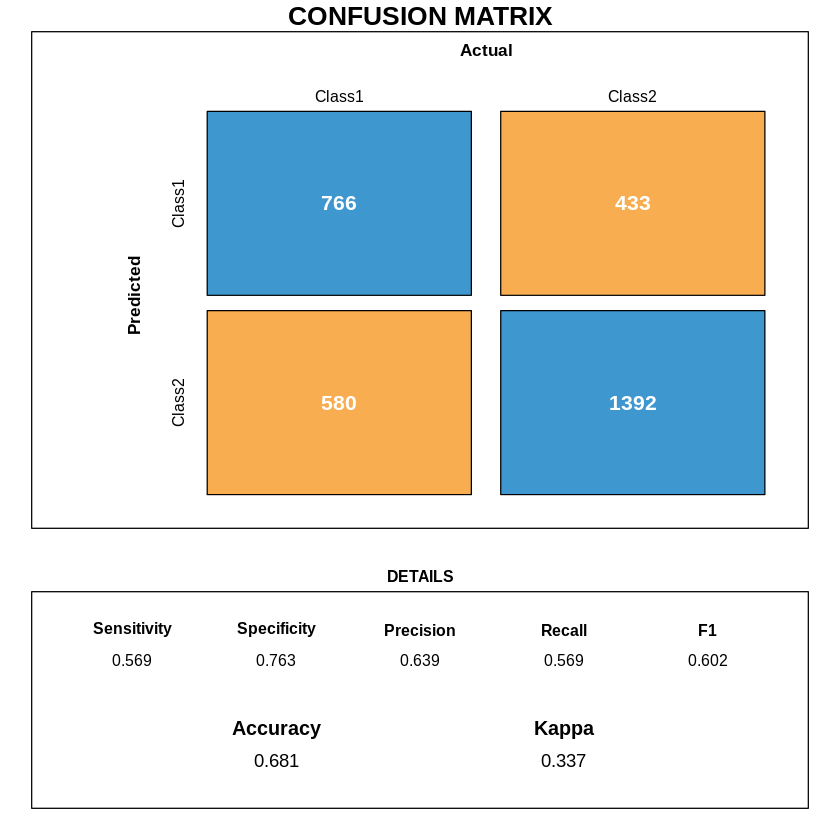

In [ ]:
# calculate the confusion matrix
cm <- confusionMatrix(data = as.factor(y_pred), reference = as.factor(test_df$Y))
draw_confusion_matrix(cm)

## A posteriori analysis for Lasso model

The model we found with the Lasso performs quite well but there is still a problem. In fact, it sets many dummy variables to zero but it does not discard all the dummy variables of a particular variable. This means that we cannot completely say that a variable is completely useless, because the model is still considering some of its dummies variables to make the prediction. To overcome this problem, we do an a posteriori analysis on the model variable. We basically tried to remove (set to zero) those variable which most of their coefficients are zero or that are very low. We removed the following variables: Occupation, Carry_Away, RestaurantLessThan20, Restaurant20To50. The Occupation variable has the 'Healthcare' coefficient which is high compared to the other and therefore it may seem not the right choice to remove it, the model is giving high importance to it. However, we must consider that, this high value, could be due to the pre-processing phase we did at the beginning. In fact, to try to reduce the dimensionality of the occupation variable, we have put together works that are in similar fields and, in this dataset, there are lot of job related to the medical field so we pooled together in the Healthcare variable. Basically we have introduced a bias to the model, but we cannot know a priori whether it is right or not.
Finally we tried to remove all the variables which, once removed, lead to a model with an accuracy greater than 68%. We get a model that achieves an accuracy of 68.15%, roughly the same as the previous one, so we can say that those variables are not useful for the prediction.

In [ ]:
# try to remove occupation variable

model_apost_lasso <- lasso_classifier_2
model_apost_lasso$beta[29:40] <- 0 # indices of occupation dummy variables

#model_apost_lasso$beta #uncomment to see the modified coefficent
y_pred <- predict(model_apost_lasso, X_test, type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results without occupation variable:",round(accuracy,4)*100,"%")

Accuracy results without occupation variable: 68.09 %

In [ ]:
# try to remove the Carry_Away Variable
model_apost_lasso <- lasso_classifier_2
model_apost_lasso$beta[54:57] <- 0
# model_apost_lasso$beta
y_pred <- predict(model_apost_lasso, X_test, type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results without income variable:",round(accuracy,4)*100,"%")

Accuracy results without income variable: 68.27 %

In [ ]:
# try to remove the RestaurantLessThan20 Variable
model_apost_lasso <- lasso_classifier_2
model_apost_lasso$beta[58:61] <- 0

#model_apost_lasso$beta
y_pred <- predict(model_apost_lasso, X_test, type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results without income variable:",round(accuracy,4)*100,"%")

Accuracy results without income variable: 68.12 %

In [ ]:
# try to remove the Restaurant20To50 Variable
model_apost_lasso <- lasso_classifier_2
model_apost_lasso$beta[62:66] <- 0

# model_apost_lasso$beta
y_pred <- predict(model_apost_lasso, X_test, type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results without income variable:",round(accuracy,4)*100,"%")

Accuracy results without income variable: 67.83 %

In [ ]:
# try to remove the three variables which models (without them) have an anccuracy above 68%
model_apost_lasso <- lasso_classifier_2
model_apost_lasso$beta[29:40] <- 0
model_apost_lasso$beta[54:61] <- 0

y_pred <- predict(model_apost_lasso, X_test, type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results without income variable:",round(accuracy,4)*100,"%")

Accuracy results without income variable: 68.15 %

In [ ]:
model_apost_lasso$beta

68 x 1 sparse Matrix of class "dgCMatrix"
                                                                        s0
destinationNo Urgent Place                                      0.57977538
destinationWork                                                 .         
passangerFriend(s)                                              0.19950306
passangerKid(s)                                                -0.17261058
passangerPartner                                                0.09164976
sunny_daySunny                                                  0.48556301
temperature12.8                                                 0.02200658
temperature26.7                                                 0.01718316
time10PM                                                       -0.12350394
time2PM                                                         .         
time6PM                                                         0.17992361
time7AM                                                   

# ElasticNet


The two above models, Ridge and Lasso, can be combined in Elastic Net. Elastic Net uses the regularization of ridge and lasso together. It then eliminates the irrelevant but not informative and useful ones. We want to tune both λ and α. For the first one, we use glmnet package with cross-validation. For the second one, we use caret.

In [ ]:
registerDoParallel(cores = 4)

In [ ]:
lam_ellastic <- seq(from = 0.0008, to = 0.003, length.out = 100)

In [ ]:
# ELASTIC NET WITH 0 < ALPHA < 1
a <- seq(0.1, 0.9, 0.05)
search <- foreach(i = a, .combine = rbind) %dopar% {
  cv <- cv.glmnet(X_train, y_train, family = "binomial", nfold = 10, type.measure = "class", lambda = lam, paralle = TRUE,standardize=FALSE, alpha = i)
  data.frame(cvm = cv$cvm[cv$lambda == cv$lambda.min], lambda.min = cv$lambda.min, alpha = i)
}
cv3 <- search[search$cvm == min(search$cvm), ]

elasticNet_classifier <- glmnet(X_train, y_train, family = "binomial", lambda = cv3$lambda[1],standardize=FALSE, alpha = cv3$alpha[1])
coef(elasticNet_classifier)

69 x 1 sparse Matrix of class "dgCMatrix"
                                                                        s0
(Intercept)                                                    -0.34449501
destinationNo Urgent Place                                      0.74972666
destinationWork                                                -0.05837153
passangerFriend(s)                                              0.24437166
passangerKid(s)                                                -0.32606014
passangerPartner                                                0.24609837
sunny_daySunny                                                  0.48932302
temperature12.8                                                 0.21175357
temperature26.7                                                 0.12119736
time10PM                                                       -0.18374028
time2PM                                                        -0.09174049
time6PM                                                   

In [ ]:
y_pred <- predict(elasticNet_classifier, X_test, type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0

accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results for ElasticNet model:",round(accuracy,4)*100,"%")

Accuracy results for ElasticNet model: 68.12 %

In [ ]:
cv3$alpha[1]
cat("Best lambda for ElasticNet model",round(elasticNet_classifier$lambda[1],5))

[1] 0.55

Best lambda for ElasticNet model 1e-04

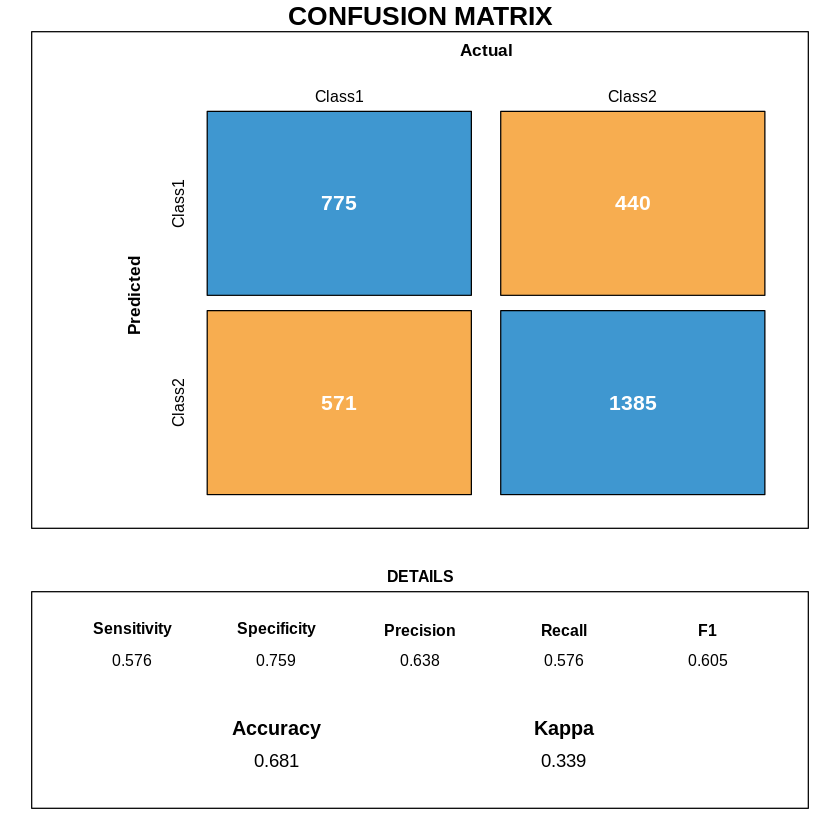

In [ ]:
# calculate the confusion matrix
cm <- confusionMatrix(data = as.factor(y_pred), reference = as.factor(test_df$Y))
draw_confusion_matrix(cm)

Elastic net was able to reach an accuracy of 68.02%, a bit higher than the previous models.

# A posteri

All the categories coefficient in a variable less than 0.3 in either ridge regression coefficient or lasso regression coefficient or elastic net coefficient, then the variables were dropped in the dataframe. The least important variable was eliminated in the dataset every time until the accuracy diminished significantly. Total fifteen features were eliminated at the end, including toCoupon_GEQ25min, has_children, toCoupon_GEQ15min, RestaurantLessThan20, CarryAway, income,maritalStatus, temperature,Bar, time, gender, age, education, occupation, Restaurant20To50. 

In [ ]:
new_train_df = data.frame(train_df)
new_train_df = subset(new_train_df,select = -c(toCoupon_GEQ25min, has_children, toCoupon_GEQ15min, RestaurantLessThan20, CarryAway, income,maritalStatus, temperature,Bar, time, gender, age, education, occupation, Restaurant20To50))
summary(new_train_df)
new_test_df = data.frame(test_df)
new_test_df = subset(new_test_df,select = -c(toCoupon_GEQ25min, has_children, toCoupon_GEQ15min, RestaurantLessThan20, CarryAway, income,maritalStatus, temperature,Bar, time, gender, age, education, occupation, Restaurant20To50))
summary(new_test_df)

 destination         passanger          sunny_day            coupon         
 Length:9487        Length:9487        Length:9487        Length:9487       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  expiration        CoffeeHouse  direction_same        Y         
 Length:9487        1~3  :2419   Min.   :0.000   Min.   :0.0000  
 Class :character   4~8  :1359   1st Qu.:0.000   1st Qu.:0.0000  
 Mode  :character   gt8  : 839   Median :0.000   Median :1.0000  
                    less1:2592   Mean   :0.216   Mean   :0.5657  
                    never:2278   3rd Qu.:0.000   3rd Qu.:1.0000  
                                 Max.   :1.000   Max.   :1.0000  

 destination         passanger          sunny_day            coupon         
 Length:3171        Length:3171        Length:3171        Length:3171       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  expiration        CoffeeHouse direction_same         Y         
 Length:3171        1~3  :836   Min.   :0.0000   Min.   :0.0000  
 Class :character   4~8  :439   1st Qu.:0.0000   1st Qu.:0.0000  
 Mode  :character   gt8  :276   Median :0.0000   Median :1.0000  
                    less1:837   Mean   :0.2129   Mean   :0.5755  
                    never:733   3rd Qu.:0.0000   3rd Qu.:1.0000  
                    NA's : 50   Max.   :1.0000   Max.   :1.0000  

In [ ]:
# MICE for test set
# impute test data based on train imputation model
my_imp = mice(new_train_df,m=1,method=c("","","","","","polyreg","",""), maxit=20)
new_test_imp <- mice.mids(my_imp, new_test_df, maxit = 20)
final_clean_dataset = complete(new_test_imp,1)
new_test_imp = final_clean_dataset

# Note: The imputation model itself is specified in the mice() 
# function and cannot be changed with mice.mids. The state of 
# the random generator is saved with the mids object.
new_X_test <- model.matrix(Y~.,new_test_imp)
new_X_test <- new_X_test[,-1]

In [ ]:
############################
#     RIDGE REGRESSION     #
############################

# design matrix 

new_X_train <- model.matrix(Y~.,new_train_df)

# remove the first column relative to the intercept 

new_X_train <- new_X_train[,-1]

# vector of responses

new_y_train <- new_train_df$Y

# grid of lambda values

lam <- seq(from = 0.00001, to = 0.005, length.out = 150)



# ten folds cross-validation 

set.seed(42)
new_ridge_classifier.cv <- cv.glmnet(new_X_train, new_y_train, alpha = 0, nfolds = 10, lambda = lam,
                              type.measure = 'deviance',  family = 'binomial',  standardize=FALSE)



cat("Best lambda for Ridge Regression",round(new_ridge_classifier.cv$lambda.min,7))




Best lambda for Ridge Regression 0.0001105

In [ ]:
new_ridge_classifier <- glmnet(new_X_train, new_y_train , alpha=0, 
                              lambda=new_ridge_classifier.cv$lambda.min, family='binomial',standardize=FALSE)
coef(new_ridge_classifier)

17 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)                 -0.4828498
destinationNo Urgent Place   0.6534931
destinationWork             -0.1093526
passangerFriend(s)           0.1475460
passangerKid(s)             -0.4614526
passangerPartner             0.1537978
sunny_daySunny               0.5571389
couponCarry out & Take away  1.5038942
couponCoffee House           0.4395353
couponRestaurant(<20)        1.4219404
couponRestaurant(20-50)      0.2771607
expiration2h                -0.8194068
CoffeeHouse4~8              -0.1733325
CoffeeHousegt8              -0.4835840
CoffeeHouseless1            -0.5943856
CoffeeHousenever            -0.9860688
direction_same               0.4674901

In [ ]:
y_pred <- predict(new_ridge_classifier,new_X_test,type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == new_test_df$Y)
cat("Accuracy results for Ridge Regression model:",round(accuracy,4)*100,"%")

Accuracy results for Ridge Regression model: 67.61 %

In [ ]:
############################
#     LASSO REGRESSION     #
############################


# design matrix 

new_X_train <- model.matrix(Y~.,new_train_df)

# remove the first column relative to the intercept 

new_X_train <- new_X_train[,-1]

# vector of responses

new_y_train <- new_train_df$Y

# grid of lambda values

lam <- seq(from = 0.0001, to = 0.005, length.out = 150)

# Apply glmnet() function

# classifier  <- glmnet(X_train ,y_train , alpha=1, lambda = lam, family = 'binomial',standardize=FALSE) # FALSE becuase are ll categorical variable
# also because this normalization depends a lot on the frequency
#classifier


# ten folds cross-validation 

set.seed(42)
new_lasso_classifier.cv <- cv.glmnet(new_X_train, new_y_train , alpha = 1, nfolds = 10, lambda = lam,
                              type.measure = 'deviance',  family = 'binomial',  standardize=FALSE)


cat("Best lambda for the Lasso model",round(classifier.cv$lambda.min,5))




Best lambda for the Lasso model 0.00049

In [ ]:
new_lasso_classifier <- glmnet(new_X_train,new_y_train , alpha=1, 
                                lambda=new_lasso_classifier.cv$lambda.min, family='binomial',standardize=FALSE)
coef(new_lasso_classifier)


17 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)                 -0.4853254
destinationNo Urgent Place   0.6551424
destinationWork             -0.1075288
passangerFriend(s)           0.1429442
passangerKid(s)             -0.4607285
passangerPartner             0.1475107
sunny_daySunny               0.5573494
couponCarry out & Take away  1.5057569
couponCoffee House           0.4387122
couponRestaurant(<20)        1.4229840
couponRestaurant(20-50)      0.2740676
expiration2h                -0.8186122
CoffeeHouse4~8              -0.1675567
CoffeeHousegt8              -0.4781870
CoffeeHouseless1            -0.5906077
CoffeeHousenever            -0.9831474
direction_same               0.4645256

In [ ]:
y_pred <- predict(new_lasso_classifier,new_X_test,type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0
accuracy <- mean(y_pred == new_test_df$Y)
cat("Accuracy results for Lasso Regression model:",round(accuracy,4)*100,"%")

Accuracy results for Lasso Regression model: 67.58 %

In [ ]:
registerDoParallel(cores = 4)

In [ ]:
lam_ellastic <- seq(from = 0.0008, to = 0.003, length.out = 100)

In [ ]:
# ELASTIC NET WITH 0 < ALPHA < 1
a <- seq(0.1, 0.9, 0.05)
search <- foreach(i = a, .combine = rbind) %dopar% {
  cv <- cv.glmnet(new_X_train, new_y_train, family = "binomial", nfold = 10, type.measure = "class", lambda = lam, paralle = TRUE,standardize=FALSE, alpha = i)
  data.frame(cvm = cv$cvm[cv$lambda == cv$lambda.min], lambda.min = cv$lambda.min, alpha = i)
}
cv3 <- search[search$cvm == min(search$cvm), ]

elasticNet_classifier <- glmnet(new_X_train, new_y_train, family = "binomial", lambda = cv3$lambda[1],standardize=FALSE, alpha = cv3$alpha[1])
coef(elasticNet_classifier)

17 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)                 -0.4782479
destinationNo Urgent Place   0.6488685
destinationWork             -0.1071398
passangerFriend(s)           0.1453004
passangerKid(s)             -0.4539292
passangerPartner             0.1455809
sunny_daySunny               0.5563749
couponCarry out & Take away  1.4895598
couponCoffee House           0.4258217
couponRestaurant(<20)        1.4072604
couponRestaurant(20-50)      0.2594510
expiration2h                -0.8137313
CoffeeHouse4~8              -0.1599348
CoffeeHousegt8              -0.4682548
CoffeeHouseless1            -0.5826380
CoffeeHousenever            -0.9738976
direction_same               0.4597256

In [ ]:
y_pred <- predict(elasticNet_classifier, new_X_test, type="response")
y_pred[y_pred >= 0.5] <- 1
y_pred[y_pred < 0.5] <- 0

accuracy <- mean(y_pred == new_test_df$Y)
cat("Accuracy results for ElasticNet model:",round(accuracy,4)*100,"%")

Accuracy results for ElasticNet model: 67.58 %

# Support Vector Machine

To increase the performance we can try to use  more complicated models. In this case we have decided to use Support Vector Machine (SVM), which are supervised learning methods used for classification and also for regression. Without going into detail, the main idea behind SVMs is to find a hyperplane that best divides the dataset into the two classes. Thanks to this method we can achieve an accuracy of 74.05%, an increase of about 6 % compared to previous models. This increment in performance is due to the fact we are exploiting non-linear relationships between variables (thanks to the kernel trick). These types of methods are very powerful but suffer from a huge disadvantages: it is very difficult to make inferences with them. Basically we cannot look at the coefficient of the model to try to understand which variables are important and which are not. So in the end, if our goal is to build the best model in terms of performance, it is okay to use this type of methods, or even more complicated ones, but if the task, like in our case, is to understand the role of each variable to make the right prediction it is better to choose simpler models, like the previous ones.

In [ ]:
# Fitting SVM to the Training set
svmfit = svm(x = X_train, y = y_train, kernel = "radial", gamma = 0.1,type = 'C-classification', scale = FALSE)
summary(svmfit)


Call:
svm.default(x = X_train, y = y_train, scale = FALSE, type = "C-classification", 
    kernel = "radial", gamma = 0.1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  6649

 ( 3232 3417 )


Number of Classes:  2 

Levels: 
 0 1




In [ ]:
y_pred <- predict(svmfit, X_test, type="response")
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results for SVM model:",round(accuracy,4)*100,"%")

Accuracy results for SVM model: 74.05 %

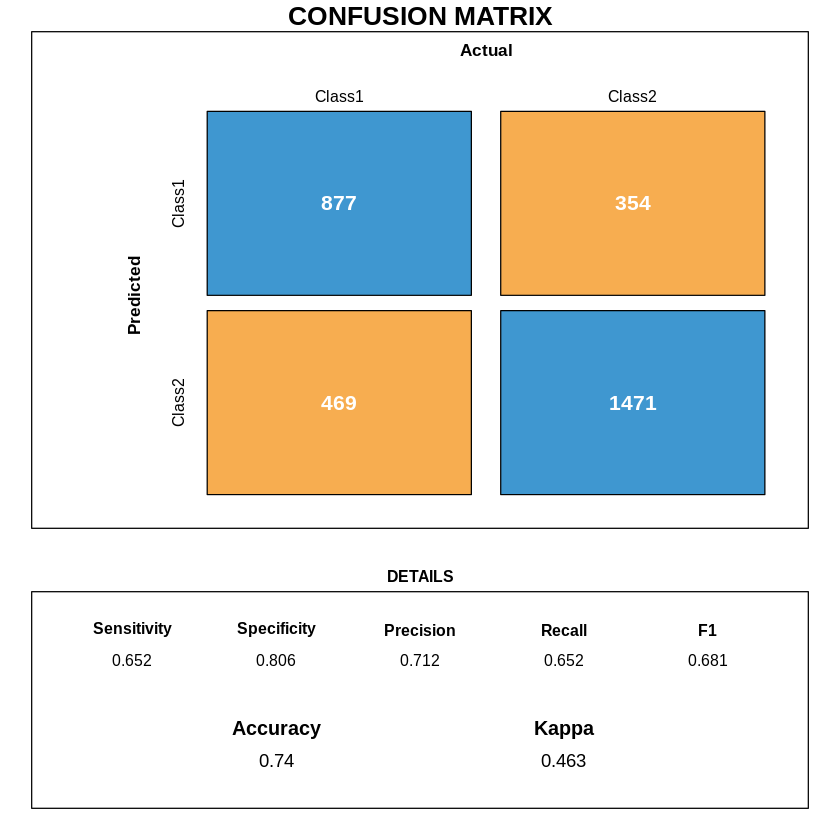

In [ ]:
# calculate the confusion matrix
cm <- confusionMatrix(data = as.factor(y_pred), reference = as.factor(test_df$Y))
draw_confusion_matrix(cm)

# Threshold

Below we plot the ROC curve and we calculated the Area Under the Curve (AUC) to evaluate how good is our model. The ROC is a probability curve that plots the TPR against FPR at various threshold. The perfect model will reach the upper left corner, but it is very difficult to make, especially in our case that we are only exploiting the linear relationship between the variables. The AUC instead is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points. Our model achieve 0.7404 which is a quite good result.

In [ ]:
# find the right threshold in the training set 
y_prob <- predict(model_apost_lasso, X_train,type="response")
roc.out <- roc(y_train, y_prob, levels=c(0,1))


Area Under the Curve: 0.7404

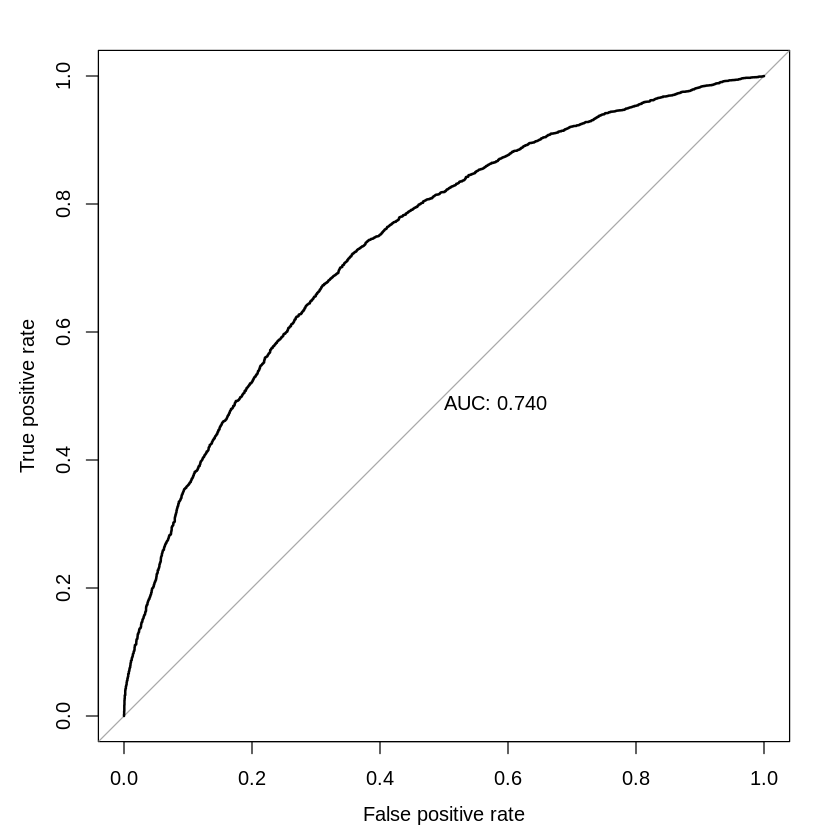

In [ ]:
plot(roc.out, print.auc=TRUE, legacy.axes=TRUE,xlab="False positive rate", ylab="True positive rate",col = 'black')
cat("Area Under the Curve:",round(auc(roc.out), 4))

In the next graph we plot the overall error rate (black line), the error rate for individuals who will accept the coupon (red line) and the error rate for the ones who will not accept the coupon (blu line). This graph could be very useful to understand in wich direction we need to change the threshold to try to minimize one of these two error rate.

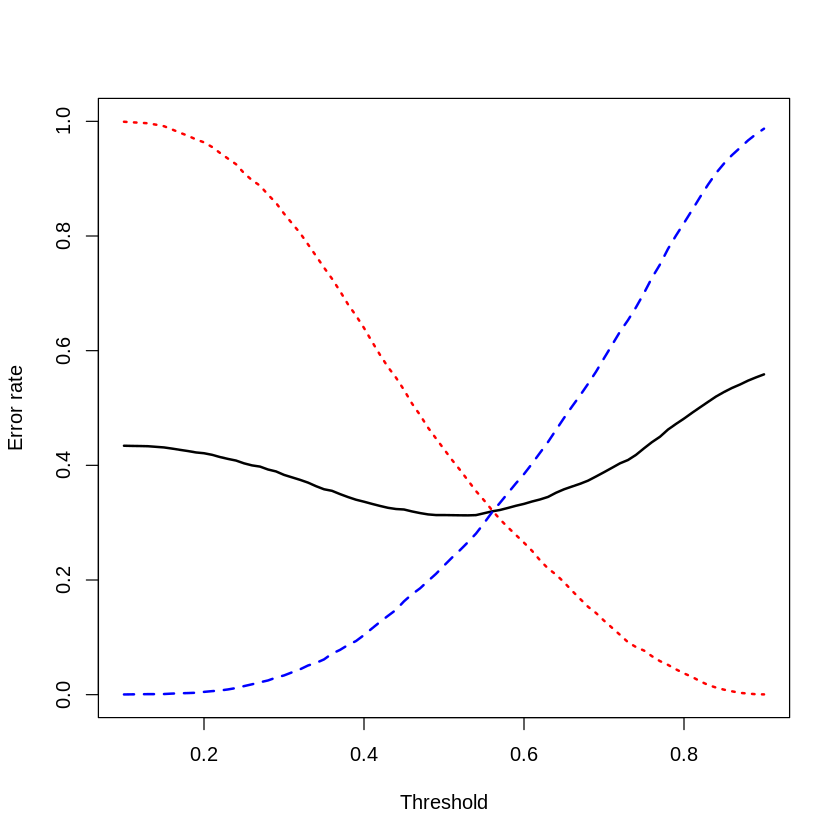

In [ ]:
overall_err <- c()
pos_err <- c()
neg_err <- c()

thr <- seq(from = 0.1, to = 0.9, length.out = 100)
thr <- round(thr, digits = 2)
for (i in thr) {
  y_prob <- predict(model_apost_lasso,X_train,type="response")
  y_pred[y_prob >= i] <- 1
  y_pred[y_prob < i] <- 0
  t <- table(y_pred, y_train)
  # overall (training) error rate
  overall_err <- c(overall_err, (t[2]+t[3])/ sum(t[1:4]))
  # (training) error rate for individuals who will not accept the coupon
  pos_err <- c(pos_err, t[3]/(t[3]+t[4]))
  # (training) error rate for individuals who will accept the coupon
  neg_err <- c(neg_err, t[2]/(t[1]+t[2]))
}

# plot the results
# plot solid line, set plot size, but omit axes
plot(x = thr, y = overall_err, type="l", lty=1, lwd =2, ylim =c(0,1),
     xlab = "Threshold", ylab = "Error rate")

# plot dashed line
lines(x = thr, y = pos_err, lwd =2, col = 'blue', lty=2)
# plot dashed line
lines(x = thr, y = neg_err, lwd =2, col ='red', lty=3)


To choose the right threshold we need to understand well what are the goals of the person who commissioned the work and what happen if we reduce or increase one of the two error rate. So we need to decided if we want to minimize the error for those who will accept the coupon (true positive) or for those who will not accept it. A person who accepts the coupon is more likely to go to that particular restaurant and spend money, so if we get the wrong prediction for that person, we risk to "lose" his money. In the other case, if we make the wrong prediction for a person who will not accept the coupon, we risk, in the worst case, to waste the coupon. The price of a coupon is very low, around ten cents, but a person could spend a lot of money in a restaurant. We also have to consider that we are building this model for a hypothetical restaurant owner, so he is interested in making as much money as possible. With these promises it seems correct to build a naive model that always predict the positive class. However we need to consider two important thing. The first is that building such a model is useless because we are not making any inference and the model only predicting to give the coupon to everyone. The second thing is that we need to make a trade off between performance and time (not money). Trying to give a coupon to someone who doesn't accept it is just a waste of time and this could be a problem if the number of people starts to increase too much. We can notice that this problem occurs in real life, when we see someone outside the buildings spending hours and hours trying to give coupons to random people.
To conclude we are more interested in building a model that is able to correctly predict as many true positives as possible without increasing the true negative error rate too much. From the graph above we deduce that, if we want to achieve these results, we must increase the threshold. Below we reported the error rate for different model with different threshold. The best model is the one with the threshold equal to 0.65. If we keep increasing it, the overall error rate and the error rate for those who will not accept the coupon starts to increase too much. With this threshold we conclude with an overall error rate slightly worse than the standard model, which has a threshold of 0.5  (35.82 % vs 31.33%). The huge improvement, however, lies in the error rate for those who will accept the coupon (true positive), in fact we reduce the error from 42.82% to 19.61%. Of course we end up with a worse error rate for those who will not accept it but, as we said before, we are not interested to minimize this error.

In [ ]:
# threshold equal to 0.5
ind_5 <-match(0.5, thr)
cat("Threshold equal to 0.50\n")
cat("Overall error rate:", round(overall_err[ind_5], 4)*100, "%\n")
cat("Error rate for individuals who will accept the coupon:",round(neg_err[ind_5], 4)*100, "%\n")
cat("Error rate for individuals who will not accept the coupon:",round(pos_err[ind_5], 4)*100, "%")


Threshold equal to 0.50
Overall error rate: 31.33 %
Error rate for individuals who will accept the coupon: 42.82 %
Error rate for individuals who will not accept the coupon: 22.51 %

In [ ]:
# threshold equal to 0.55
ind_55 <-match(0.55, thr)
cat("Threshold equal to 0.55\n")
cat("Overall error rate:", round(overall_err[ind_55], 4)*100, "%\n")
cat("Error rate for individuals who will accept the coupon:",round(neg_err[ind_55], 4)*100, "%\n")
cat("Error rate for individuals who will not accept the coupon:",round(pos_err[ind_55], 4)*100, "%")



Threshold equal to 0.55
Overall error rate: 31.64 %
Error rate for individuals who will accept the coupon: 33.91 %
Error rate for individuals who will not accept the coupon: 29.9 %

In [ ]:
# threshold equal to 0.6
ind_6 <-match(0.6, thr)
cat("Threshold equal to 0.60\n")
cat("Overall error rate:", round(overall_err[ind_6], 4)*100, "%\n")
cat("Error rate for individuals who will accept the coupon:",round(neg_err[ind_6], 4)*100, "%\n")
cat("Error rate for individuals who will not accept the coupon:",round(pos_err[ind_6], 4)*100, "%")




Threshold equal to 0.60
Overall error rate: 33.28 %
Error rate for individuals who will accept the coupon: 26.5 %
Error rate for individuals who will not accept the coupon: 38.48 %

In [ ]:
# threshold equal to 0.65
ind_65 <-match(0.65, thr)
cat("Threshold equal to 0.65\n")
cat("Overall error rate:", round(overall_err[ind_65], 4)*100, "%\n")
cat("Error rate for individuals who will accept the coupon:",round(neg_err[ind_65], 4)*100, "%\n")
cat("Error rate for individuals who will not accept the coupon:",round(pos_err[ind_65], 4)*100, "%")


Threshold equal to 0.65
Overall error rate: 35.82 %
Error rate for individuals who will accept the coupon: 19.61 %
Error rate for individuals who will not accept the coupon: 48.26 %

In [ ]:
# threshold equal to 0.7
ind_7 <-match(0.7, thr)
cat("Threshold equal to 0.7\n")
cat("Overall error rate:", round(overall_err[ind_7], 4)*100, "%\n")
cat("Error rate for individuals who will accept the coupon:",round(neg_err[ind_7], 4)*100, "%\n")
cat("Error rate for individuals who will not accept the coupon:",round(pos_err[ind_7], 4)*100, "%")


Threshold equal to 0.7
Overall error rate: 38.8 %
Error rate for individuals who will accept the coupon: 12.91 %
Error rate for individuals who will not accept the coupon: 58.67 %

In [ ]:
# plot the confusion matrix of the final model
y_pred <- predict(model_apost_lasso,X_test,type="response")
y_pred[y_pred >= 0.65] <- 1
y_pred[y_pred < 0.65] <- 0
accuracy <- mean(y_pred == test_df$Y)
cat("Accuracy results for Lasso Regression model with 0.65 of threshold:",round(accuracy,4)*100,"%")

Accuracy results for Lasso Regression model with 0.65 of threshold: 61.87 %

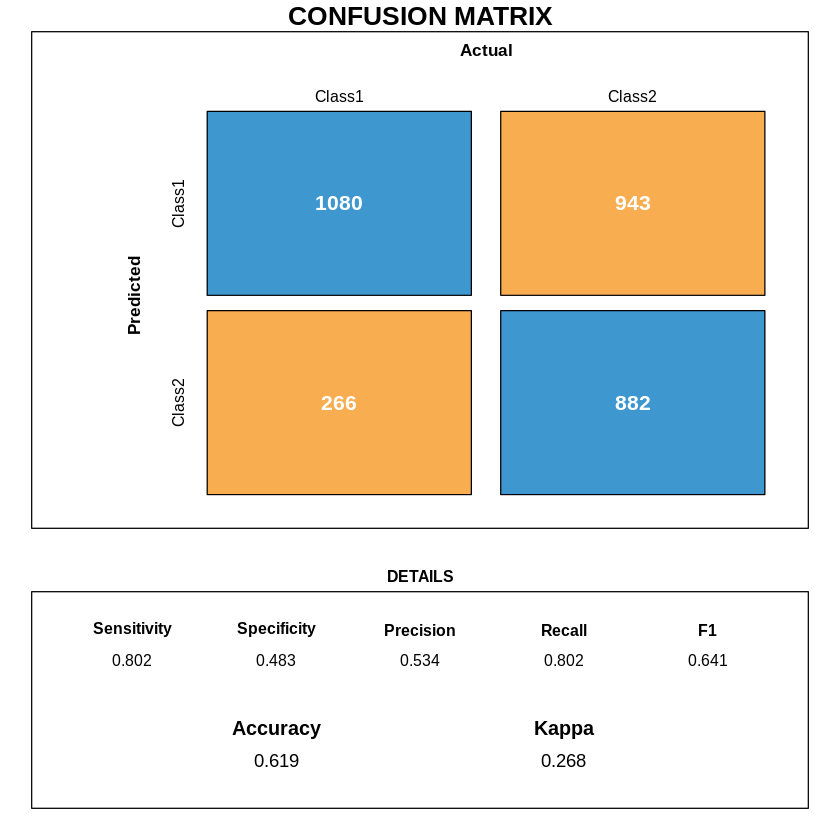

In [ ]:
# calculate the confusion matrix
cm <- confusionMatrix(data = as.factor(y_pred), reference = as.factor(test_df$Y))
draw_confusion_matrix(cm)

#**Conclusion**
Preprocessing data, including data type changing, eliminating meaningless data, dimensions reduction and filling up NA data, was involved to prepare the data for predicting whether the driver will accept the coupon under different scenarios. The best regression architecture was found by testing with different parameters and regularization methods (ridge, lasso and elastic net), where Lasso was the best regression architecture. Then, comparing the accuracy between the best regression model and a SVM model. The best regression model scored around 68% accuracy in the testing dataset, which was a satisfying result for us. 

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc


Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-latex-extra set to manually installed.
texlive-xetex is already the newest version (2017.20180305-1).
The following NEW packages will be installed:
  texlive
0 upgraded, 1 newly installed, 0 to remove and 48 not upgraded.
Need to get 14.4 kB of archives.
After this operation, 70.7 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 texlive all 2017.20180305-1 [14.4 kB]
Fetched 14.4 kB in 0s (58.9 kB/s)
Selecting previously unselected package texlive.
(Reading database ... 186957 files and directories currently installed.)
Preparing to unpack .../texlive_2017.20180305-1_all.deb ...
Unpacking texlive (2017.20180305-1) ...
Setting up texlive (2017.20180305-1) ...
  Created w

In [ ]:
!cp drive/My Drive/Colab Notebooks/

cp: target 'Notebooks/' is not a directory


In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/Prova pdf di SL_project.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Prova pdf di SL_project.ipynb to PDF
[NbConvertApp] Support files will be in Prova pdf di SL_project_files/
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Prova pdf di SL_project.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Prova pdf di SL_project.ipynb to pdf
[NbConvertApp] Support files will be in Prova pdf di SL_project_files/
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_files
[NbConvertApp] Making directory ./Prova pdf di SL_project_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'